# EnKF数据同化

## 1 导入相关库

In [1]:
%matplotlib inline
import sys, os
import copy
import datetime as dt
import pcse
from Wofost_opt_NWLP import my_crop_dict, my_agro, ModelRerunner
from pcse.fileinput import YAMLCropDataProvider, CABOFileReader, YAMLAgroManagementReader
from pcse.exceptions import PCSEError, PartitioningError
from pcse.util import WOFOST80SiteDataProvider
from pcse.base import ParameterProvider
from pcse.fileinput import YAMLAgroManagementReader
from pcse.fileinput import ExcelWeatherDataProvider
from pcse.models import Wofost80_NWLP_FD_beta as Wofost80_NWLP_FD
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

--- Logging error ---
Traceback (most recent call last):
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\Dongh\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\Dongh\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "d:\anaconda3\envs\pcse\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\anaconda3\envs\pcse\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\anaconda3\envs\pcse\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\anaconda3\envs\pcse\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.s

This notebook was built with:
python version: 3.8.15 (default, Nov  4 2022, 15:16:59) [MSC v.1916 64 bit (AMD64)] 
PCSE version: 5.5.4


In [227]:
data_dir = os.path.join(os.getcwd(), "data")

In [228]:
def isdir_demo(dir_path):
    if not os.path.isdir(dir_path):
        try:
            os.mkdir(dir_path)
        except FileNotFoundError:
            os.makedirs(dir_path)

## 2数据准备

### 2.1 模型输入数据

In [229]:
cropfile = os.path.join(data_dir, 'npkfile', 'wofost_npk.crop')
cropd = CABOFileReader(cropfile)
soilfile = os.path.join(data_dir, 'soil', 'ec3_copy1.soil')
soild = CABOFileReader(soilfile)

In [230]:
sited = WOFOST80SiteDataProvider(WAV=18, NAVAILI=20.5, PAVAILI=50.0, KAVAILI=250.0)

In [231]:
parameters = ParameterProvider(cropdata=cropd, soildata=soild, sitedata=sited)

In [2]:
with open("./data/npkfile/wofost_npk2022.agro", 'r') as f:
    yaml_agro_2022 = f.read()
with open("./data/npkfile/wofost_npk2021.agro", 'r') as f:
    yaml_agro_2021 = f.read()

In [8]:
yaml_ = yaml_agro_2022.replace("2022-06-11", "2020-06-10")
yaml_ = yaml_.replace("2022", "2020")
with open("./data/npkfile/wofost_npk2020.agro", 'w') as f:
    f.write(yaml_)



'Version: 1.0\nAgroManagement:\n- 2020-06-01:\n    CropCalendar:\n        crop_name: maize\n        variety_name: Grain_maize_201\n        crop_start_date: 2020-06-10\n        crop_start_type: sowing\n        crop_end_date:\n        crop_end_type: maturity\n        max_duration: 140\n    TimedEvents:\n    -   event_signal: irrigate\n        name:  Timed irrigation events\n        comment: All irrigation amounts in cm\n        events_table:\n        - 2020-06-28: {amount: 7.5, efficiency: 0.9}\n        - 2020-07-07: {amount: 7.5, efficiency: 0.9}\n        - 2020-08-08: {amount: 7.5, efficiency: 0.9}\n    -   event_signal: apply_npk\n        name:  Timed N/P/K application table\n        comment: All fertilizer amounts in kg/ha\n        events_table:\n        - 2020-06-10: {N_amount: My_N1, P_amount: 90., K_amount: 60., N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}\n        - 2020-07-15: {N_amount: My_N2, P_amount: 0., K_amount: 0., N_recovery: 0.7, P_recovery: 0.7, K_recovery: 0.7}\

In [233]:
weatherfile = os.path.join(data_dir, 'meteo', 'WOFOSTYL.xlsx')
wdp = ExcelWeatherDataProvider(weatherfile)

In [234]:
def overwrite_para(params, param_dict):
    params.clear_override()
    params.set_override("TSUMEM", 125.0)
    params.set_override("TSUM1", 1300)
    params.set_override("TSUM2", 720)
    crop_dict = my_crop_dict()

    for parname, value in param_dict.items():

        tmp_name = parname.split("00")
        if len(tmp_name) == 2:
            var_name, idx1 = tmp_name[0], int(tmp_name[1])
            if var_name == "FLTB" or var_name == "FOTB":
                crop_dict[var_name][idx1] = value
                crop_dict['FSTB'][idx1] = 1 - crop_dict['FLTB'][idx1] - crop_dict['FOTB'][idx1]
                params.set_override(var_name, crop_dict[var_name])
                params.set_override("FSTB", crop_dict["FSTB"])
                # print("%s: %s" % (var_name, parameters[var_name]))
            else:
                crop_dict[var_name][idx1] = value
                params.set_override(var_name, crop_dict[var_name])

        else:
            var_name = parname
            params.set_override(var_name, value)
    return params

In [235]:
param_df = pd.read_csv(os.path.join(data_dir, "opt", "optNWLP", "opt_ZDN180_NWLP_result3.csv"), index_col=0)
param_df.sort_values(by=['rmse'], ascending=True, inplace=True)
parameters_name = param_df.columns.to_list()
parameters_name = parameters_name[1: ]

rows, _ = param_df.shape
df_dict = dict()
for nn in [180]:
    agro = my_agro(yaml_agro_2021, nn)
    modelrerunner = None
    modelrerunner = ModelRerunner(parameters, wdp, agro)
    twso_list = list()
    for i in tqdm([1]):
        p_value = dict()
        for each in parameters_name:
            p_value[each] = param_df.iloc[i][each]
        result = modelrerunner(p_value, flag=True)
        # if result[1][0]['TWSO'] > 8000:
        twso_list.append([i, result[1][0]['TWSO']])
    df1 = pd.DataFrame(twso_list, columns=["id", "TWSO"])
    df1.set_index("id", inplace=True)
    df_dict[str(nn)] = df1

100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


<AxesSubplot:xlabel='day'>

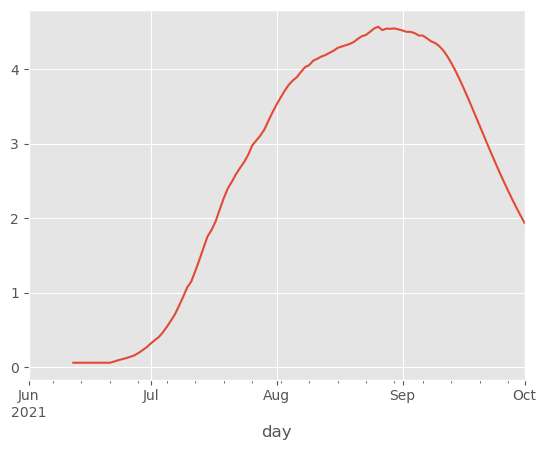

In [236]:
result[0].LAI.plot()

In [237]:
df_model = result[0]

### 2.2观测数据

In [428]:
pathDA = "./data/data4DA/ZDN180Y2021.csv"
obs_DA = pd.read_csv(pathDA)
obs_DA.index = pd.to_datetime(obs_DA.day).dt.date

In [429]:
variables_for_DA = ["LAI", "TAGP"]
dates_of_observation = obs_DA.index.to_list()
observed_lai = obs_DA.LAI_O.to_numpy()
std_lai = observed_lai * 0.05 # Std. devation is estimated as 10% of observed value                                                                 
observed_tagp = obs_DA.TAGP_O.to_numpy()
std_tagp = observed_tagp * 0.05 # Std. devation is estimated as 5% of observed value
observations_for_DA = []
# Pack them into a convenient format
for d, lai, errlai, tagp, errtagp in zip(dates_of_observation, observed_lai, std_lai, observed_tagp, std_tagp):
    observations_for_DA.append((d, {"LAI":(lai, errlai), "TAGP":(tagp, errtagp)}))

### 2.3 Plot modelled and observed states
We will now combine the default WOFOST run and the satellite observations in a single figure.

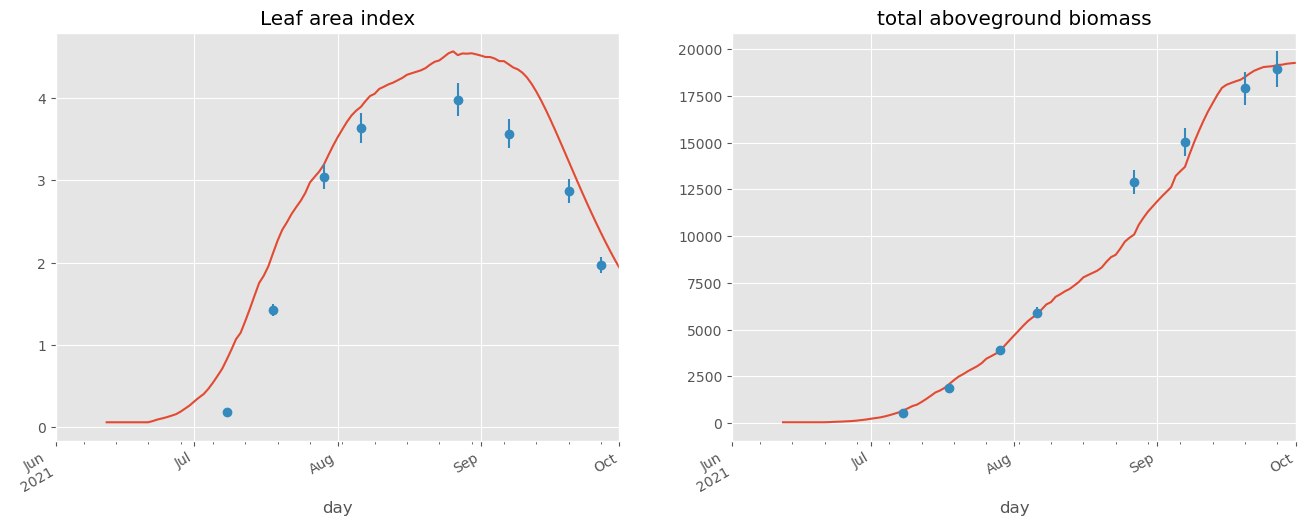

In [430]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
df_model.LAI.plot(ax=axes[0], label="leaf area index")
axes[0].errorbar(dates_of_observation, observed_lai, yerr=std_lai, fmt="o")
df_model.TAGP.plot(ax=axes[1], label="total aboveground biomass")
axes[1].errorbar(dates_of_observation, observed_tagp, yerr=std_tagp, fmt="o")
axes[0].set_title("Leaf area index")
axes[1].set_title("total aboveground biomass")
fig.autofmt_xdate()

## 3 数据同化

### 3.1 同化集合

In [431]:
ensemble_size = 50
np.random.seed(1354331612)

### 3.2 设置同化参数

**均匀分布**

In [432]:
param_set = pd.read_csv("./data/opt/DA/ZD_DA1.csv", index_col=0)
# 需要调整的参数集
override_parameters = {}
# 初始条件
override_parameters["TDWI"] = np.random.normal(46.79, 2.9545, (ensemble_size))
override_parameters["WAV"] = np.random.normal(18., 1.5, (ensemble_size))
# override_parameters["NAVAILI"] = np.random.normal(20.5, 0.5, (ensemble_size))
# 参数
# override_parameters["SPAN"] = np.random.normal(43.649, 1.826346, (ensemble_size))
# override_parameters["SLATB001"] = np.random.normal(0.0022789, 0.000174 ,(ensemble_size))
# override_parameters["SLATB003"] = np.random.normal(0.001432, 0.0000483, (ensemble_size))
# override_parameters["TMNFTB003"] = np.random.normal(1.117173, 0.038879, (ensemble_size))
# override_parameters["EFFTB003"] = np.random.normal(0.496615, 0.046394, (ensemble_size))
# override_parameters["NMAXLV_TB007"] = np.random.normal(0.010456, 0.000709, (ensemble_size))
# override_parameters["NCRIT_FR"] = np.random.normal(0.750603, 0.02449, (ensemble_size))
for each in param_set.columns:
    override_parameters[each] = np.random.uniform(param_set.loc[2, each], param_set.loc[3, each], (ensemble_size))

# fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
# # Show the sample that was drawn
# for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
#     ax.hist(distr)
#     ax.set_title(par)


**高斯分布**

In [433]:
def add_gaussian_noise(data, data_size, mean=0., std=1.):
    return data + np.random.normal(mean, std, data_size)

In [434]:
parameters_name

['NAVAILI',
 'SLATB001',
 'SLATB003',
 'SPAN',
 'EFFTB003',
 'TMNFTB003',
 'CVO',
 'FLTB001',
 'TDWI',
 'CVS',
 'EFFTB001',
 'KDIFTB003',
 'NCRIT_FR',
 'AMAXTB001',
 'NMAXLV_TB003',
 'NMAXLV_TB007',
 'NRESIDLV']

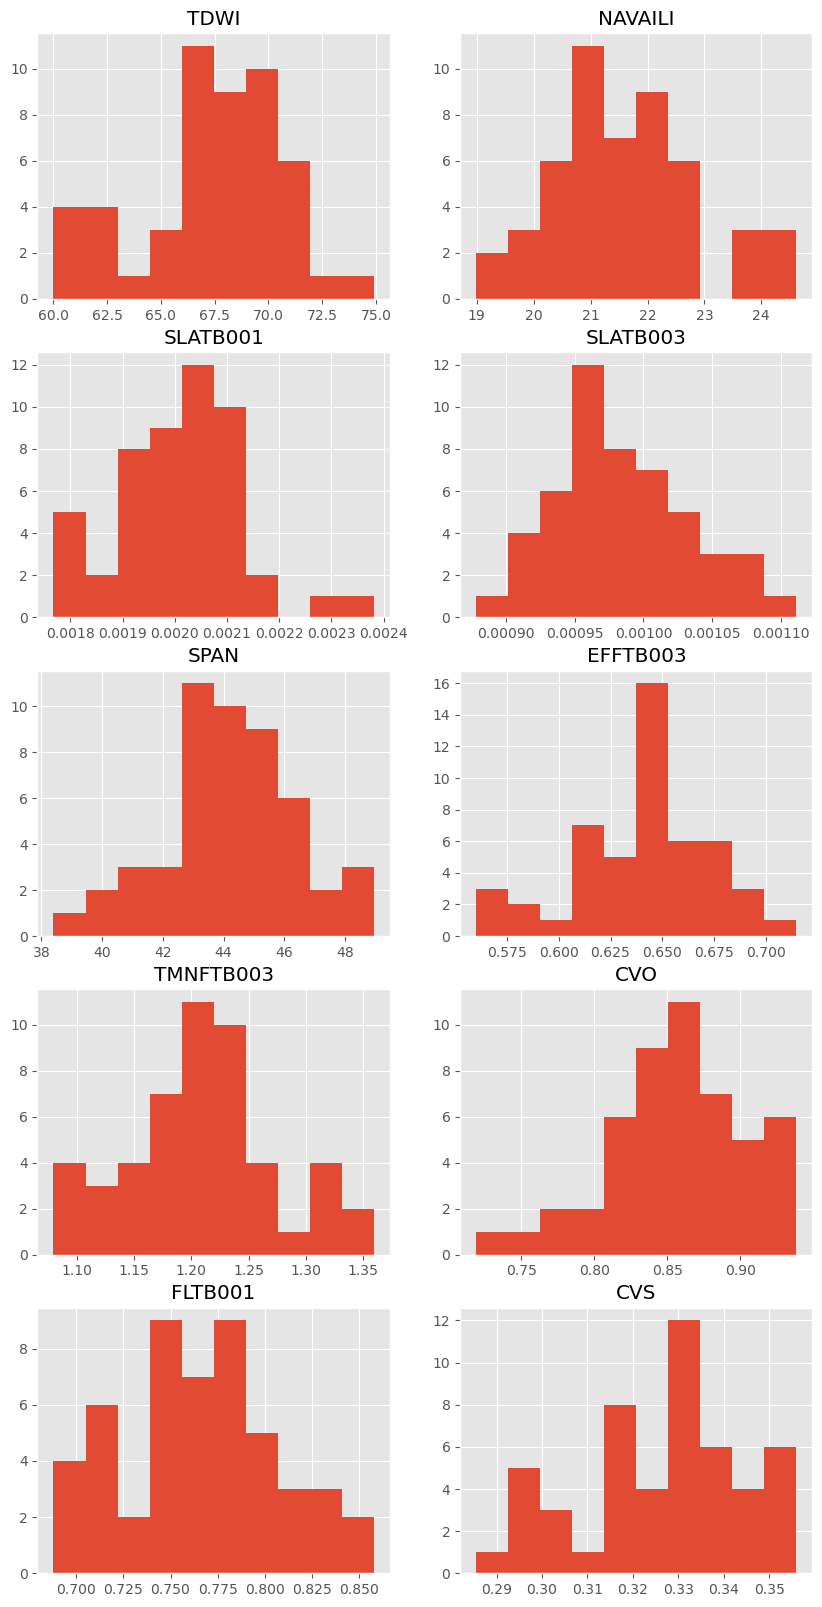

In [435]:
# 需要调整的参数集
# param_set = pd.read_csv("./data/opt/DA/ZD_DA1.csv", index_col=0)
param_name = ['SPAN',
              'TDWI',
              "CVS",
              ]
override_parameters = {}
# 初始条件
override_parameters["TDWI"] = np.random.normal(47.03964584, 2.306831177, (ensemble_size))
# override_parameters["WAV"] = np.random.normal(18., 1.5, (ensemble_size))
# override_parameters["NAVAILI"] = np.random.normal(20.5, 0.5, (ensemble_size))
# 参数
# override_parameters["SPAN"] = np.random.normal(43.67107082, 2.039382991, (ensemble_size))
# override_parameters["SLATB001"] = np.random.normal(0.002834115, 0.000153716 ,(ensemble_size))
# override_parameters["SLATB003"] = np.random.normal(0.001443546, 0.0000451982, (ensemble_size))
# override_parameters["TMNFTB003"] = np.random.normal(1.110052116, 0.033887947, (ensemble_size))
# override_parameters["EFFTB003"] = np.random.normal(0.508812352, 0.023041403, (ensemble_size))
# override_parameters["NMAXLV_TB007"] = np.random.normal(0.010378854, 0.00066446, (ensemble_size))
# override_parameters["NCRIT_FR"] = np.random.normal(0.750958689, 0.020258971, (ensemble_size))
# for each in param_set.columns:
#     override_parameters[each] = np.random.normal(param_set.loc[0, each], param_set.loc[1, each], (ensemble_size))
par_std = pd.read_csv("./data/opt/DA/opt_ZDN180_DA_result3.csv", index_col=0)
par_std.sort_values(by="rmse", ascending=False, inplace=True)

idx = 1
for each in parameters_name:
    value = param_df.iloc[idx][each]
    override_parameters[each] = add_gaussian_noise(value, (50, ), 0, 0.05*value)


fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)


### 3.3初始化集合

In [436]:
ensemble = []
parameters = overwrite_para(parameters, p_value)
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    tmp_dict = dict()
    for par, distr in override_parameters.items():
        tmp_dict[par] = distr[i]
    p = overwrite_para(p, tmp_dict)
    member = Wofost80_NWLP_FD(p, wdp, agro)
    ensemble.append(member)

### 3.4 Implementing the data assimilation itself
First, we define if we want to see detailed output, disabling output makes the notebook more compact as long tables will not be shown.

In [437]:
show_output = False

**计算集合均值**

In [ ]:
def cal_ensembel_mean(df_list):

    num = 0
    for df in copy.deepcopy(df_list):

        df.reset_index(inplace=True)
        try:
            df.insert(loc=0, column="group", value=num)
        except ValueError:
            print("pass")
            pass
        if num == 0:
            concat_df = df
        else:
            concat_df = pd.concat([concat_df, df], axis=0)
        num += 1

    concat_df.reset_index(inplace=True, drop=True)
    concat_df = concat_df.groupby(["day"]).mean()

    return concat_df


**以下为3.4.1-3.4.6的所有代码**

In [438]:
while len(observations_for_DA):   
    day, obs = observations_for_DA.pop(0)
    for member in ensemble:
        member.run_till(day)
    print("Ensemble now at day %s" % member.day)
    print("%s observations left!" % len(observations_for_DA))

    collected_states = []
    for member in ensemble:
        t = {}
        for state in variables_for_DA:
            t[state] = member.get_variable(state)
        collected_states.append(t)
    df_A = pd.DataFrame(collected_states)
    A = np.matrix(df_A).T
    df_A if show_output else None

    P_e = np.matrix(df_A.cov())
    df_A.cov() if show_output else None

    perturbed_obs = []
    for state in variables_for_DA:
        (value, std) = obs[state]
        d = np.random.normal(value, std, (ensemble_size))
        perturbed_obs.append(d)
    df_perturbed_obs = pd.DataFrame(perturbed_obs).T
    df_perturbed_obs.columns = variables_for_DA
    D = np.matrix(df_perturbed_obs).T
    R_e = np.matrix(df_perturbed_obs.cov())
    df_perturbed_obs if show_output else None

    # Here we compute the Kalman gain
    H = np.identity(len(obs))
    K1 = P_e * (H.T)
    K2 = (H * P_e) * H.T
    K = K1 * ((K2 + R_e).I)
    K if show_output else None

    # Here we compute the analysed states
    Aa = A + K * (D - (H * A))
    df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)
    df_Aa if show_output else None

    for member, new_states in zip(ensemble, df_Aa.itertuples()):
        r1 = member.set_variable("LAI", new_states.LAI)
        r2 = member.set_variable("TAGP", new_states.TAGP)


for member in ensemble:
    member.run_till_terminate()

results = []
for member in ensemble:
    member_df = pd.DataFrame(member.get_output()).set_index("day")
    results.append(member_df)

#集合均值
ensembel_mean_df = cal_ensembel_mean(results)

Ensemble now at day 2021-07-08
7 observations left!
Ensemble now at day 2021-07-18
6 observations left!
Ensemble now at day 2021-07-29
5 observations left!
Ensemble now at day 2021-08-06
4 observations left!


--- Logging error ---
Traceback (most recent call last):
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\Dongh\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\Dongh\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "d:\anaconda3\envs\pcse\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\anaconda3\envs\pcse\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\anaconda3\envs\pcse\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\anaconda3\envs\pcse\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.s

Ensemble now at day 2021-08-27
3 observations left!
Ensemble now at day 2021-09-07
2 observations left!
Ensemble now at day 2021-09-20
1 observations left!
Ensemble now at day 2021-09-27
0 observations left!



### 3.4.8 Run all the ensemble members until the end of the growing season

Finally, we can run the WOFOST ensemble until the end of the growing season using the `run_till_terminate()` call.


In [439]:
for member in ensemble:
    member.run_till_terminate()

--- Logging error ---
Traceback (most recent call last):
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "d:\anaconda3\envs\pcse\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] 另一个程序正在使用此文件，进程无法访问。: 'C:\\Users\\Dongh\\.pcse\\logs\\pcse.log' -> 'C:\\Users\\Dongh\\.pcse\\logs\\pcse.log.1'
Call stack:
  File "d:\anaconda3\envs\pcse\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "d:\anaconda3\envs\pcse\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "d:\anaconda3\envs\pcse\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\anaconda3\envs\pcse\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.s

## 4绘图

### 4.1 从集合中提取数据

In [440]:
results = []
for member in ensemble:
    member_df = pd.DataFrame(member.get_output()).set_index("day")
    results.append(member_df)

**计算误差**

In [441]:
pathDA = "./data/data4DA/ZDN180Y2022.csv"
obs_DA = pd.read_csv(pathDA)
obs_DA.index = pd.to_datetime(obs_DA.day)

In [442]:
i = 0
rmse_list = list()
for member_df in results:
    diff = member_df.LAI - obs_DA.LAI_O
    obj_func = np.sqrt(np.mean(diff ** 2))
    obj_func = obj_func / np.mean(obs_DA.LAI_O)

    diff1 = member_df.TAGP - obs_DA.TAGP_O
    obj_func1 = np.sqrt(np.mean(diff1 ** 2))
    obj_func1 = obj_func / np.mean(obs_DA.TAGP_O)
    nRMSE = np.mean([obj_func, obj_func1])
    rmse_list.append([i, nRMSE])
    i += 1

df_rmse = pd.DataFrame(rmse_list, columns=["id", "rmse"])
df_rmse.sort_values(by="rmse", inplace=True)
    

**计算集合均值**

### 可视化

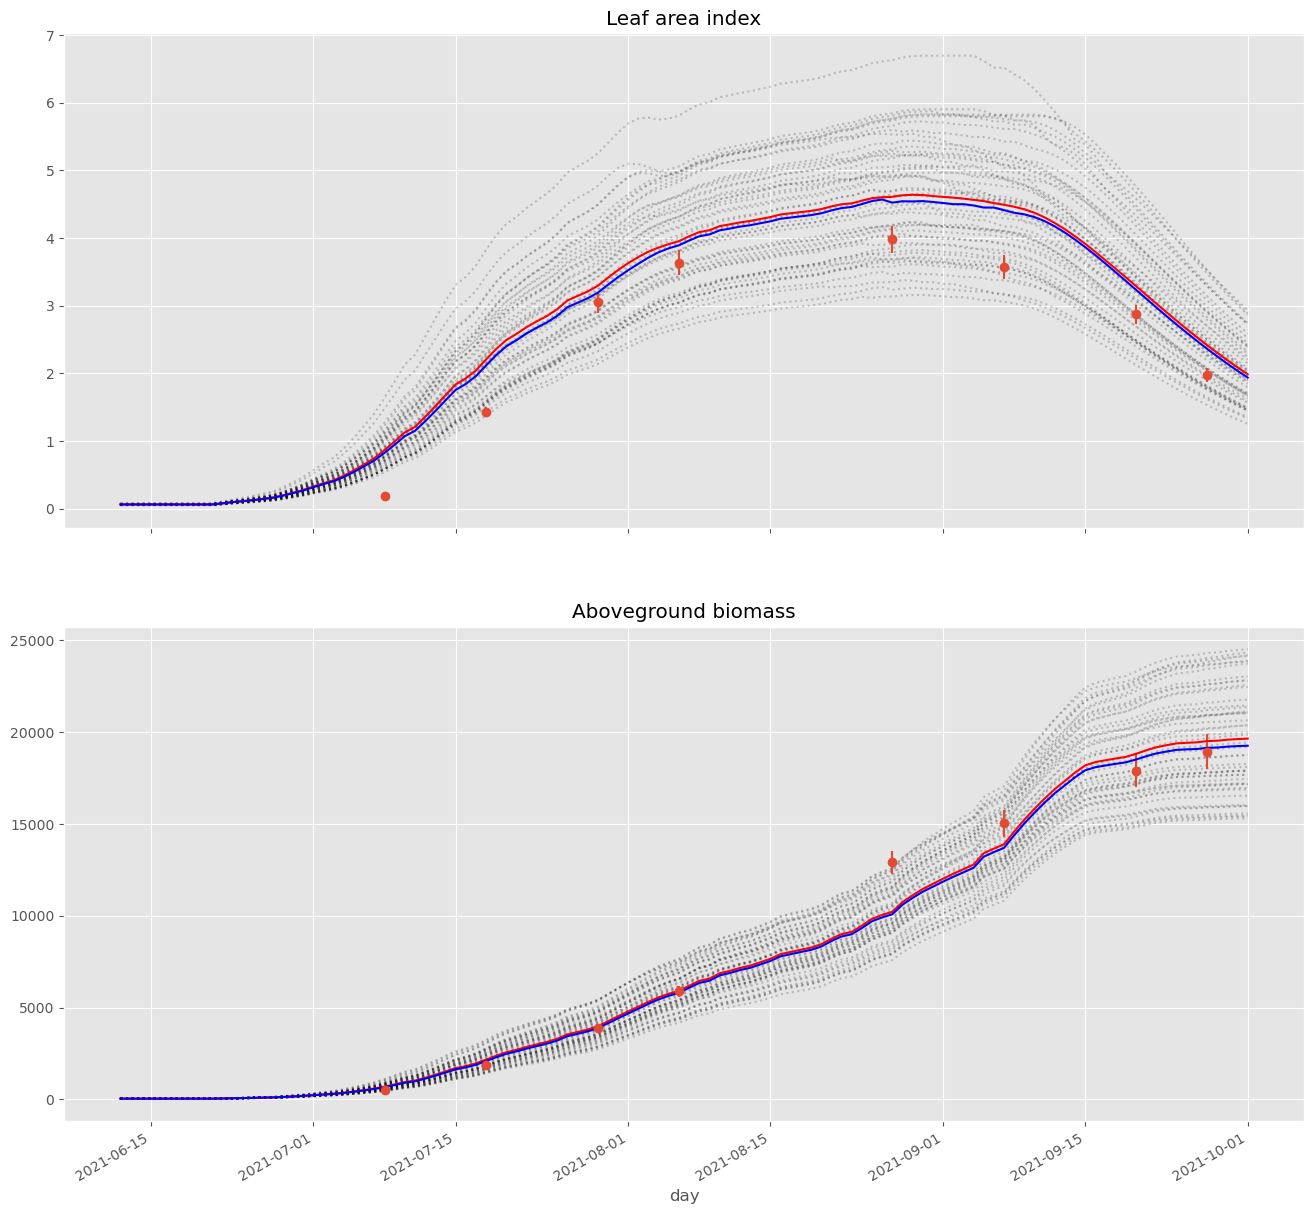

In [458]:
twso = list()
for member_df in results:
    twso.append(member_df["TWSO"][-1])

In [459]:
member_df

,DVS,LAI,TAGP,TWSO,TWLV,TWST,TWRT,TRA,RD,SM,...,KAVAIL,Ndemand,RNuptake,Pdemand,RPuptake,Kdemand,RKuptake,NamountSO,PamountSO,KamountSO
day,,,,,,,,,,,,,,,,,,,,,
2022-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335000,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.318952,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.343243,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-06-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.415367,...,250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,1.931158,2.036997,13393.862855,7650.430696,1699.398187,4044.033972,933.388981,0.075043,100.0,0.332838,...,160.661722,2.267165,2.267165,5.063014,0.0,0.0,0.0,88.306955,32.574807,34.563952
2022-09-24,1.952105,1.977770,13505.162165,7761.730006,1699.398187,4044.033972,933.388981,0.072104,100.0,0.331907,...,158.394557,2.172833,2.172833,5.337678,0.0,0.0,0.0,90.837264,33.129002,35.697815
2022-09-25,1.973299,1.916147,13598.528127,7855.095968,1699.398187,4044.033972,933.388981,0.142584,100.0,0.331030,...,156.221724,2.126893,2.126893,5.554955,0.0,0.0,0.0,93.341258,33.627777,36.785072
